In [6]:
import torch 
import numpy as np
from torch import nn
from torch.nn import functional as F
from utils import (
    SigLIPExperiment,
)
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Trainable Temperature 

In [2]:
torch.manual_seed(50)

n_classes = 20
dim = 3
n_epochs = int(1e4)
device_str = 'cuda' if torch.cuda.is_available() else 'cpu'

rb = 0
bias_is_trainable = False
temperature_is_trainable = True
# Test a range of temperatures
t = 10  # 20 evenly spaced temperatures between 10 and 50
final_losses = []
final_temps = []
final_embeddings = []

print(f"Using device: {device_str}")
print(f"Running experiments with: n_classes={n_classes}, dim={dim}, n_epochs={n_epochs}")

print(f"\nTesting temperature: {rb:.2f}")
experiment = SigLIPExperiment(
    n_classes=n_classes,
    dim=dim,
    n_epochs=n_epochs,
    device=device_str
)

U_final, V_final, criterion_final, losses_history = experiment.train(
    relative_bias=rb,
    temperature=t,
    trainable_temp=temperature_is_trainable,
    trainable_bias=bias_is_trainable
)

final_loss = losses_history[-1]
final_temp = criterion_final.get_temperature()

final_losses.append(final_loss)
final_temps.append(final_temp.detach().item())  # Detach and convert to Python scalar


print(f"Final Loss: {final_loss:.4f}")
print(f"Final Temperature: {final_temp:.4f}")

final_embeddings.append((U_final, V_final))
    #experiment.plot_inner_product_gap(U_final, V_final)
    #plt.savefig(f'logs/inner_product_gap_{rb:.2f}.png')

Using device: cpu
Running experiments with: n_classes=20, dim=3, n_epochs=10000

Testing temperature: 0.00
[100/10000]  loss=0.2621  T=6.0330  rb=0.0000
[200/10000]  loss=0.1418  T=6.3362  rb=0.0000
[300/10000]  loss=0.1314  T=6.8213  rb=0.0000
[400/10000]  loss=0.1260  T=7.4045  rb=0.0000
[500/10000]  loss=0.1218  T=8.0980  rb=0.0000
[600/10000]  loss=0.1180  T=8.9174  rb=0.0000
[700/10000]  loss=0.1141  T=9.8854  rb=0.0000
[800/10000]  loss=0.1102  T=11.0313  rb=0.0000
[900/10000]  loss=0.1062  T=12.3911  rb=0.0000
[1000/10000]  loss=0.1021  T=14.0118  rb=0.0000
[1100/10000]  loss=0.0978  T=15.9571  rb=0.0000
[1200/10000]  loss=0.0934  T=18.3088  rb=0.0000
[1300/10000]  loss=0.0889  T=21.1548  rb=0.0000
[1400/10000]  loss=0.0842  T=24.6101  rb=0.0000
[1500/10000]  loss=0.0791  T=28.9239  rb=0.0000
[1600/10000]  loss=0.0734  T=34.4974  rb=0.0000
[1700/10000]  loss=0.0674  T=41.7462  rb=0.0000
[1800/10000]  loss=0.0604  T=51.3648  rb=0.0000
[1900/10000]  loss=0.0525  T=64.5902  rb=0.00

In [3]:
Unp = U_final.cpu().detach().numpy()
Vnp = V_final.cpu().detach().numpy()
Z = Unp @ Vnp.T
minsame = np.min(np.diag(Z))
maxdifff = np.max(Z - np.eye(Z.shape[0])*3)
margin = (minsame - maxdifff)/2
print(rb, margin)

0 0.012380195315927267


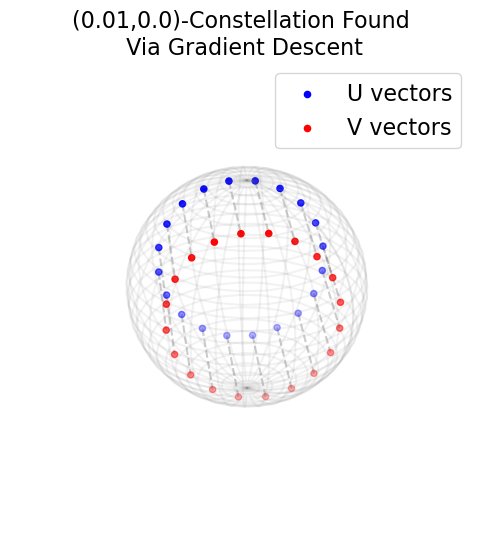

In [7]:
from utils.plottingutils import plot_vectors

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
plot_vectors(
    U_final,
    V_final,
    criterion_final,
    ax=ax,
    title=f"({float(margin):.2f},{rb:.1f})-Constellation Found\n Via Gradient Descent"
)
fig.savefig("logs/basicpicture.png", dpi=300, bbox_inches='tight')
plt.show()

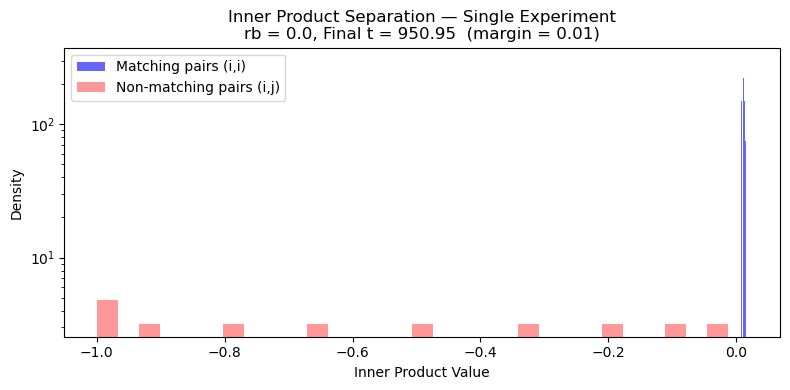

In [ ]:
# Single-experiment version (use existing final_embeddings / final_temps)
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

U_final, V_final = final_embeddings[0]
inner_products = torch.matmul(U_final, V_final.t())

# matching (diagonal) and non-matching (off-diagonal)
matching_pairs = torch.diag(inner_products).detach().cpu().numpy()
mask = ~torch.eye(n_classes, dtype=bool, device=inner_products.device)
non_matching_pairs = inner_products[mask].detach().cpu().numpy()

# small jitter for visualization if desired
matching_pairs_vis = matching_pairs.copy()
if matching_pairs_vis.size > 1:
    matching_pairs_vis = matching_pairs_vis + 0.002 * np.random.normal(size=matching_pairs_vis.shape)

minsame = np.min(matching_pairs)
maxdiff = np.max(non_matching_pairs)
margin = (minsame - maxdiff) / 2

ax.hist(matching_pairs_vis, bins=15, alpha=0.6, label='Matching pairs (i,i)', color='blue', density=True, log=True)
ax.hist(non_matching_pairs, bins=30, alpha=0.4, label='Non-matching pairs (i,j)', color='red', density=True, log=True)

title = f"rb = {rb:.1f}, Final t = {final_temps[0]:.2f}"
if margin > 0:
    title += f"  (margin = {margin:.2f})"
ax.set_title("Inner Product Separation — Single Experiment\n" + title, fontsize=12)
ax.set_xlabel('Inner Product Value', fontsize=10)
ax.set_ylabel('Density', fontsize=10)
ax.legend(fontsize=10)

plt.tight_layout()
plt.savefig("logs/single_experiment_inner_product_separation.png", dpi=300, bbox_inches='tight')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

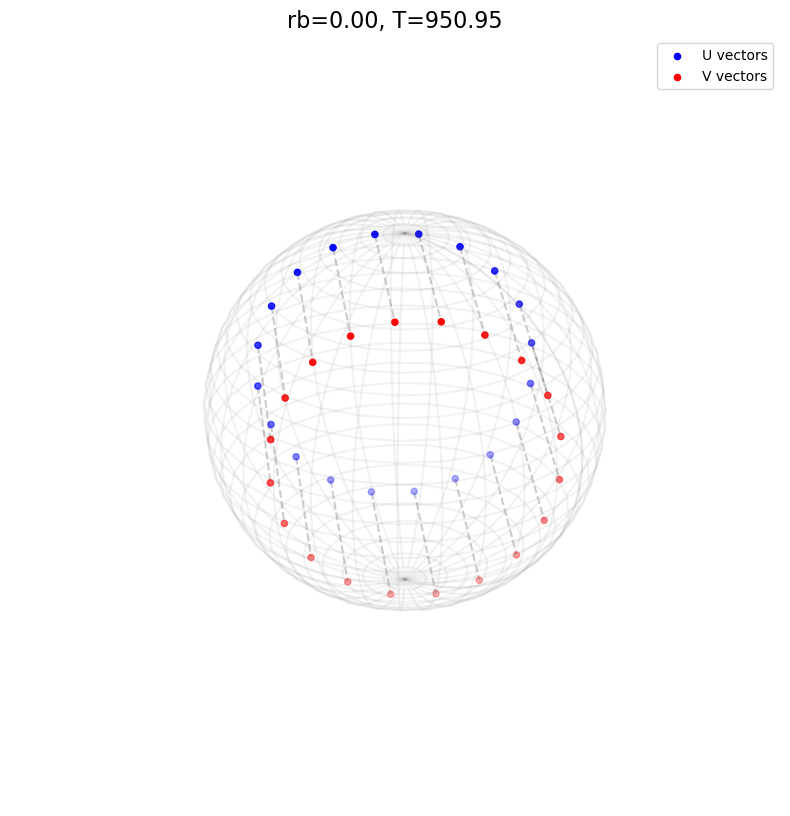

In [10]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
experiment.plot_vectors(
        U_final,
        V_final,
        criterion_final,
        ax=ax
    )
ax.legend()
plt.show